# Input Data

In [3]:
import pandas as pd
titanic=pd.read_csv("/Users/macbookpro/Documents/GitHub/Machine-Learning/data/titanic.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic.drop(['PassengerId','Name','SibSp','Parch','Ticket','Cabin','Embarked'],axis='columns',inplace=True)
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoder = LabelEncoder()
titanic['Sex'] = label_encoder.fit_transform(titanic['Sex'])  # male = 1, female = 0
#titanic['Pclass'] = label_encoder.fit_transform(titanic['Pclass'])  # male = 1, female = 0
titanic = pd.get_dummies(titanic, columns=['Pclass'], prefix='Pclass')
titanic[['Pclass_1', 'Pclass_2', 'Pclass_3']] = titanic[['Pclass_1', 'Pclass_2', 'Pclass_3']].map(int)
titanic.head()

,Survived,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3
0,0,1,22.0,7.2500,0,0,1
1,1,0,38.0,71.2833,1,0,0
2,1,0,26.0,7.9250,0,0,1
3,1,0,35.0,53.1000,1,0,0
4,0,1,35.0,8.0500,0,0,1


In [5]:
inputs=titanic.drop('Survived',axis='columns')
target=titanic.Survived

In [6]:
inputs.Age[:10] #có nghĩa nó đang truy cập vào code 'Age' của DataFrame có tên là 'inputs' và lấy ra 10 giá trị đầu tiên trong cột đó

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
5     NaN
6    54.0
7     2.0
8    27.0
9    14.0
Name: Age, dtype: float64

In [7]:
inputs.Age=inputs.Age.fillna(inputs.Age.median()) #sẽ thay thế tất cả các giá trị thiếu (NaN) trong cột 'Age' bằng giá trị trung bình mà bạn vừa tính toán
inputs.head()

,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3
0,1,22.0,7.2500,0,0,1
1,0,38.0,71.2833,1,0,0
2,0,26.0,7.9250,0,0,1
3,0,35.0,53.1000,1,0,0
4,1,35.0,8.0500,0,0,1


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(inputs, target, test_size=0.2, random_state=42);

In [9]:
X_train.shape, Y_train.shape

((712, 6), (712,))

In [10]:
X_test.shape, Y_test.shape

((179, 6), (179,))

# Decision Tree

## Dùng thư viện có sẵn

In [13]:
from sklearn import tree
model=tree.DecisionTreeClassifier(max_depth=5, min_samples_split=13)
#max_depth: độ sâu tối đa của cây quyết định, min_samples_split: số mẫu tối thiểu để chia một node

In [14]:
model.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=13)

In [15]:
test_score=model.score(X_test, Y_test)
train_score=model.score(X_train,Y_train)

print(f"Train Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")

Train Accuracy: 0.8539
Test Accuracy: 0.8045


### Kiểm tra bằng Learning curve
- Kiểm tra quá trình học bằng cách vẽ độ chính xác (hoặc lỗi) theo số lượng dữ liệu huấn luyện
- Nếu khoảng cách giữa train_score và test_score quá lớn, mô hình bị overfitting
- Nếu cả 2 đều thấp (mô hình bị underfitting)

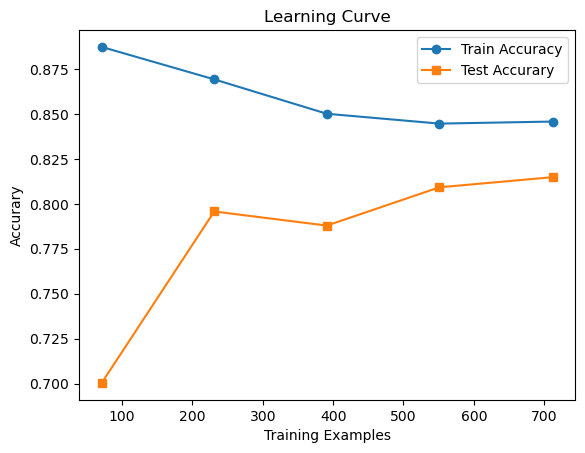

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores=learning_curve(model, inputs, target, cv=5, scoring='accuracy')

#Tính trung bình và độ lệch chuẩn
train_mean=np.mean(train_scores, axis=1)
test_mean=np.mean(test_scores, axis=1)

#Vẽ đồ thị
plt.plot(train_sizes, train_mean, label="Train Accuracy", marker='o')
plt.plot( train_sizes,test_mean, label="Test Accurary", marker='s')

plt.xlabel("Training Examples")
plt.ylabel("Accurary")
plt.title("Learning Curve")
plt.legend()
plt.show()

## Tự built model Decision Tree

### Tính Entropy

In [20]:
def entropy(y):
    classes, counts = np.unique(y, return_counts=True)
    #print(classes,counts)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities))
    

### Tính Infromation gain

In [22]:
def information_gain_continuous(y, left_indices, right_indices):
    total_entropy = entropy(y)
    
    left_entropy = entropy(y[left_indices])
    right_entropy = entropy(y[right_indices])
    
    left_weight = np.sum(left_indices) / len(y)
    right_weight = np.sum(right_indices) / len(y)
    
    weighted_entropy = left_weight * left_entropy + right_weight * right_entropy
    
    return total_entropy - weighted_entropy

In [23]:
def information_gain_discrete(X, y, feature_index):
    total_entropy = entropy(y)
    values, counts = np.unique(X[:, feature_index], return_counts=True)
    weighted_entropy = sum((counts[i] / sum(counts)) * entropy(y[X[:, feature_index] == values[i]]) for i in range(len(values)))
    return total_entropy - weighted_entropy

### Tìm đặc trưng tốt nhất

In [25]:
def best_split_combined(X, y, discrete_features):
    best_feature = None
    best_threshold = None
    best_gain = 0
    
    for feature_index in range(X.shape[1]):  
        if feature_index in discrete_features:  #thuộc tính rời rạc
            gain = information_gain_discrete(X, y, feature_index)
            threshold = None  
        else:  #thuộc tính liên tục
            unique_values = np.unique(X[:, feature_index])
            if len(unique_values) < 2:  # Không đủ giá trị để tạo threshold
                continue
            possible_thresholds = (unique_values[:-1] + unique_values[1:]) / 2
            
            for threshold in possible_thresholds:
                left_indices = X[:, feature_index] <= threshold
                right_indices = X[:, feature_index] > threshold
                
                # Bỏ qua nếu một trong hai nhóm rỗng
                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue
                
                gain = information_gain_continuous(y, left_indices, right_indices)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold
            continue 
        
        if gain > best_gain:
            best_gain = gain
            best_feature = feature_index
            best_threshold = None

    return (best_feature, best_threshold) if best_gain > 0 else (None, None)


### Cấu trúc của 1 nút trong Decision Tree

In [27]:
class DecisionTreeNode:
    def __init__(self, feature=None, value=None, left=None, right=None, prediction=None):
        self.feature = feature
        self.value = value  
        self.left = left
        self.right = right
        self.prediction = prediction


### Xây dưng Decision Tree

In [29]:
def build_tree(X, y, discrete_features, depth=0, max_depth=7, min_samples_split=10):
    if len(y) == 0:
        return None
    
    if len(np.unique(y)) == 1 or len(y) < min_samples_split or depth >= max_depth:
        return DecisionTreeNode(prediction=np.bincount(y).argmax() if len(y) > 0 else 0)
    
    feature, threshold = best_split_combined(X, y, discrete_features)

    if feature is None:
        return DecisionTreeNode(prediction=np.bincount(y).argmax() if len(y) > 0 else 0)
    
    if threshold is None:
        left_indices = X[:, feature] == 0
        right_indices = X[:, feature] == 1
    else: 
        left_indices = X[:, feature] <= threshold
        right_indices = X[:, feature] > threshold

    if not np.any(left_indices) or not np.any(right_indices):
        return DecisionTreeNode(prediction=np.bincount(y).argmax())
    
    left_subtree = build_tree(X[left_indices], y[left_indices], discrete_features, depth + 1, max_depth, min_samples_split)
    right_subtree = build_tree(X[right_indices], y[right_indices], discrete_features, depth + 1, max_depth, min_samples_split)
    
    return DecisionTreeNode(feature=feature, value=threshold, left=left_subtree, right=right_subtree)

In [30]:
print(X_test.dtypes)  # Kiểm tra kiểu dữ liệu của từng cột
print(X_test[:5])     # Kiểm tra giá trị thực tế

Sex           int64
Age         float64
Fare        float64
Pclass_1      int64
Pclass_2      int64
Pclass_3      int64
dtype: object
     Sex   Age     Fare  Pclass_1  Pclass_2  Pclass_3
709    1  28.0  15.2458         0         0         1
439    1  31.0  10.5000         0         1         0
840    1  20.0   7.9250         0         0         1
720    0   6.0  33.0000         0         1         0
39     0  14.0  11.2417         0         0         1


### Duyệt cây, dự đoán nhãn của x

In [32]:
def predict(tree, x):
    #print(tree.feature)
    if tree is None or tree.prediction is not None:
        return tree.prediction if tree else 0
    
    if tree.value is None:
        return predict(tree.left, x) if x[tree.feature] == 0 else predict(tree.right, x)
    
    return predict(tree.left, x) if x[tree.feature] <= tree.value else predict(tree.right, x)


### Tìm bộ max_depth và min_samples_split tốt nhất

In [34]:
# In ra index của các cột Pclass1, Pclass2, Pclass3 và Sex
pclass_indices = [X_train.columns.get_loc(col) for col in ["Pclass_1", "Pclass_2", "Pclass_3"]]
sex_index = X_train.columns.get_loc("Sex")

print(f"Index của Pclass: {pclass_indices}") 
print(f"Index của Sex: {sex_index}")

# Lưu danh sách cột rời rạc
discrete_features = pclass_indices + [sex_index]

Index của Pclass: [3, 4, 5]
Index của Sex: 0


In [35]:
best_acc = 0
best_params = (None, None)
param_grid = [(d, s) for d in range(1, 7) for s in range(10, 21, 5)]

for max_depth, min_samples_split in param_grid:
    custom_tree = build_tree(X_train.to_numpy(), Y_train, discrete_features, max_depth=max_depth, min_samples_split=min_samples_split)
    Y_pred_test = np.array([predict(custom_tree, x) for x in X_test.to_numpy()])
    test_acc = np.mean(Y_pred_test == Y_test)
    
    if test_acc > best_acc:
        best_acc = test_acc
        best_params = (max_depth, min_samples_split)

### Huấn luyện vs model tốt nhất

In [37]:
final_tree = build_tree(X_train.to_numpy(), Y_train, discrete_features, max_depth=best_params[0], min_samples_split=best_params[1])

Y_pred_train = np.array([predict(final_tree, x) for x in X_train.to_numpy()])
Y_pred_test = np.array([predict(final_tree, x) for x in X_test.to_numpy()])

train_acc = np.mean(Y_pred_train == Y_train)
test_acc = np.mean(Y_pred_test == Y_test)

print(f"Best max_depth: {best_params[0]}, Best min_samples_split: {best_params[1]}")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Best max_depth: 3, Best min_samples_split: 10
Train Accuracy: 0.8272
Test Accuracy: 0.7989


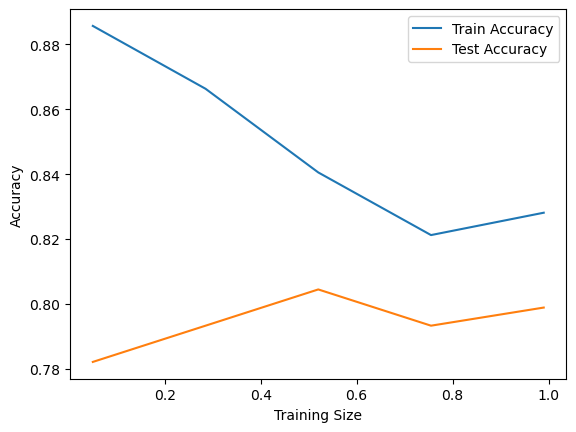

In [38]:
# Vẽ Learning Curve
train_sizes = np.linspace(0.05, 0.99, 5) 
train_accs = []
test_accs = []

for size in train_sizes:
    X_train_subset, _, Y_train_subset, _ = train_test_split(X_train, Y_train, train_size=size, random_state=42)
    temp_tree = build_tree(X_train_subset.to_numpy(), Y_train_subset, discrete_features, max_depth=best_params[0], min_samples_split=best_params[1])
    train_accs.append(np.mean([predict(temp_tree, x) for x in X_train_subset.to_numpy()] == Y_train_subset))
    test_accs.append(np.mean([predict(temp_tree, x) for x in X_test.to_numpy()] == Y_test))

plt.plot(train_sizes, train_accs, label='Train Accuracy')
plt.plot(train_sizes, test_accs, label='Test Accuracy')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()